In [1]:
from utils import *

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\up\\b7a6f709_nohash_0.wav', shape=(), dtype=string)


In [6]:
train_split = int(0.8 * num_samples)
test_split = int(0.1*num_samples + train_split)

train_data, test_data, validation_data = np.split(filenames,[train_split, test_split])

print('Training set size:', len(train_data))
print('Validation set size:', len(validation_data))
print('Test set size:', len(test_data))

Training set size: 6400
Validation set size: 800
Test set size: 800


In [7]:
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11889, 1])

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_data)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

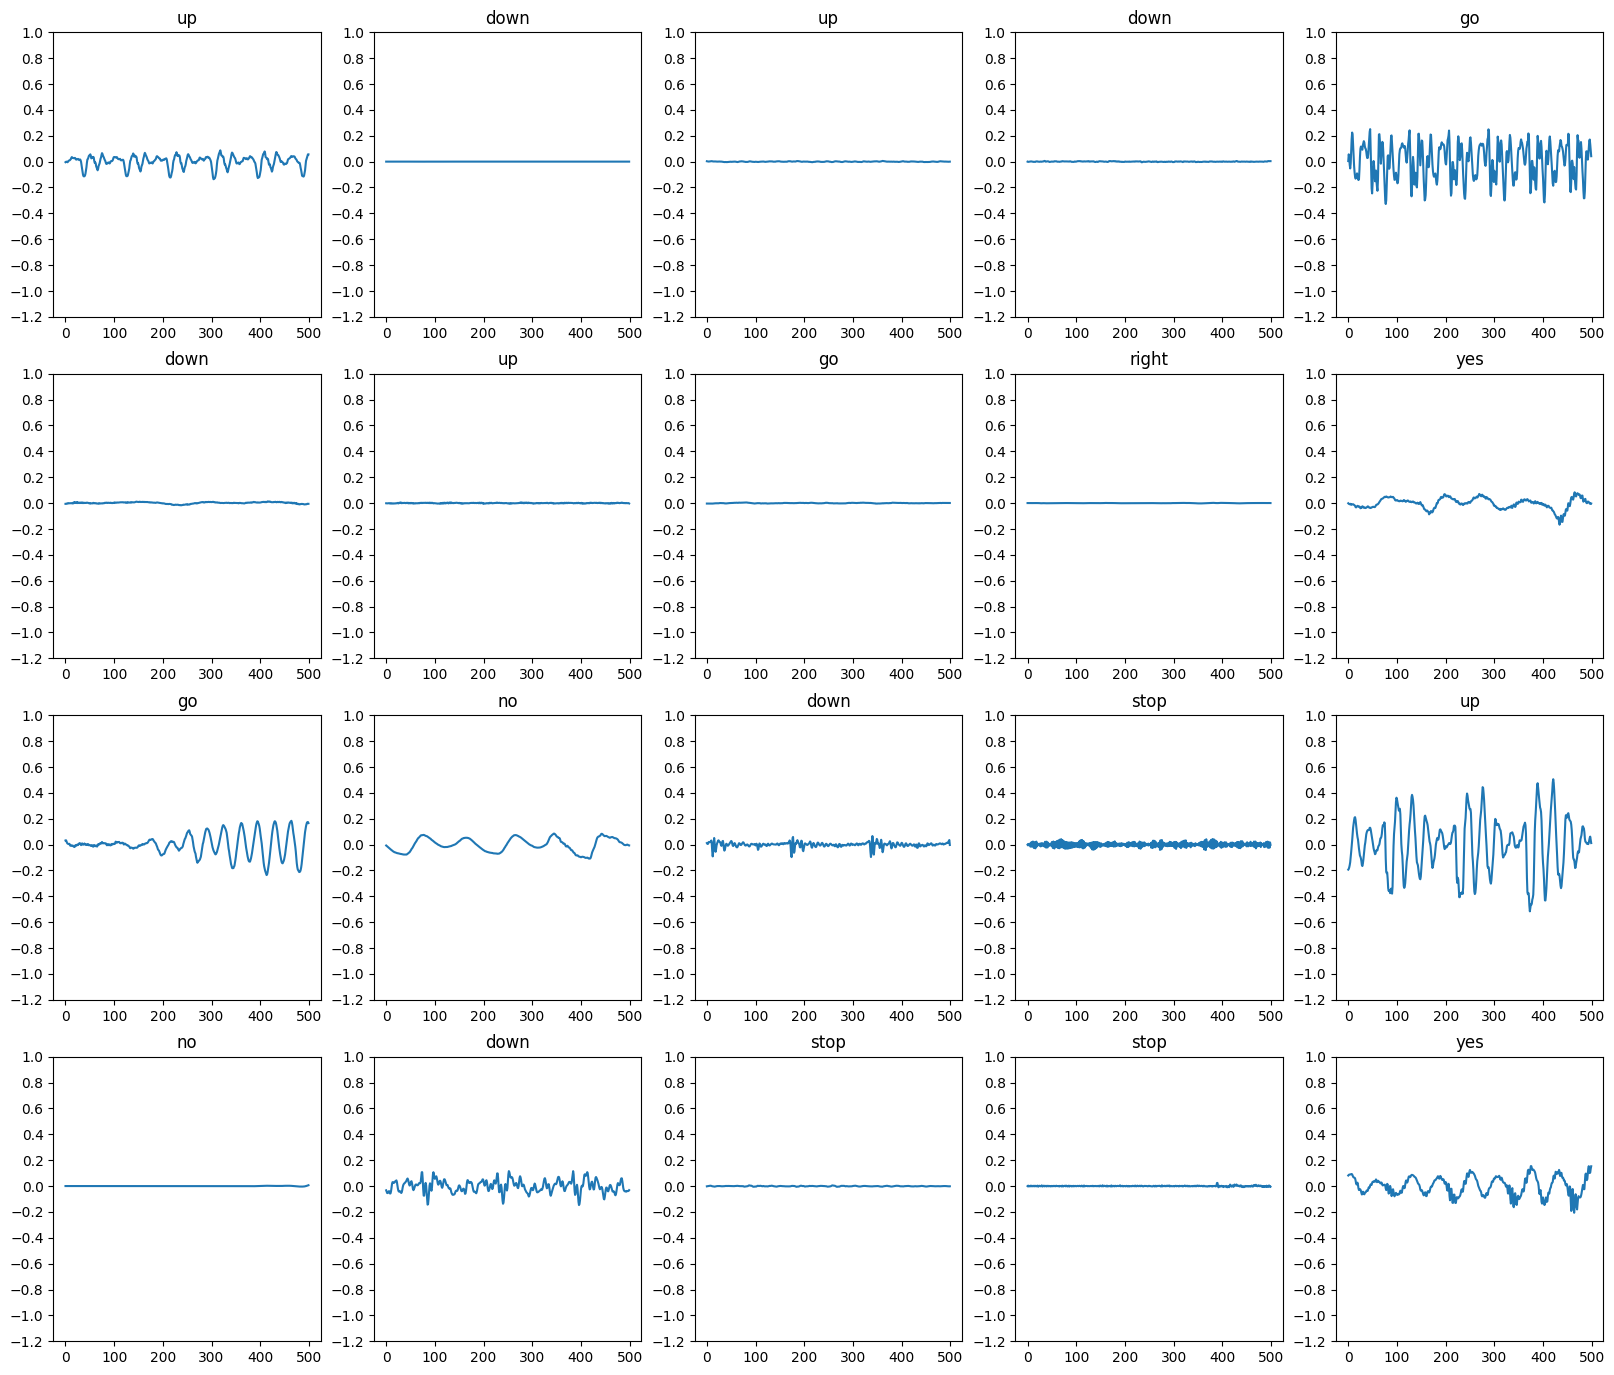

In [9]:
rows = 4
cols = 5
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 17))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy()[6000:6500])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

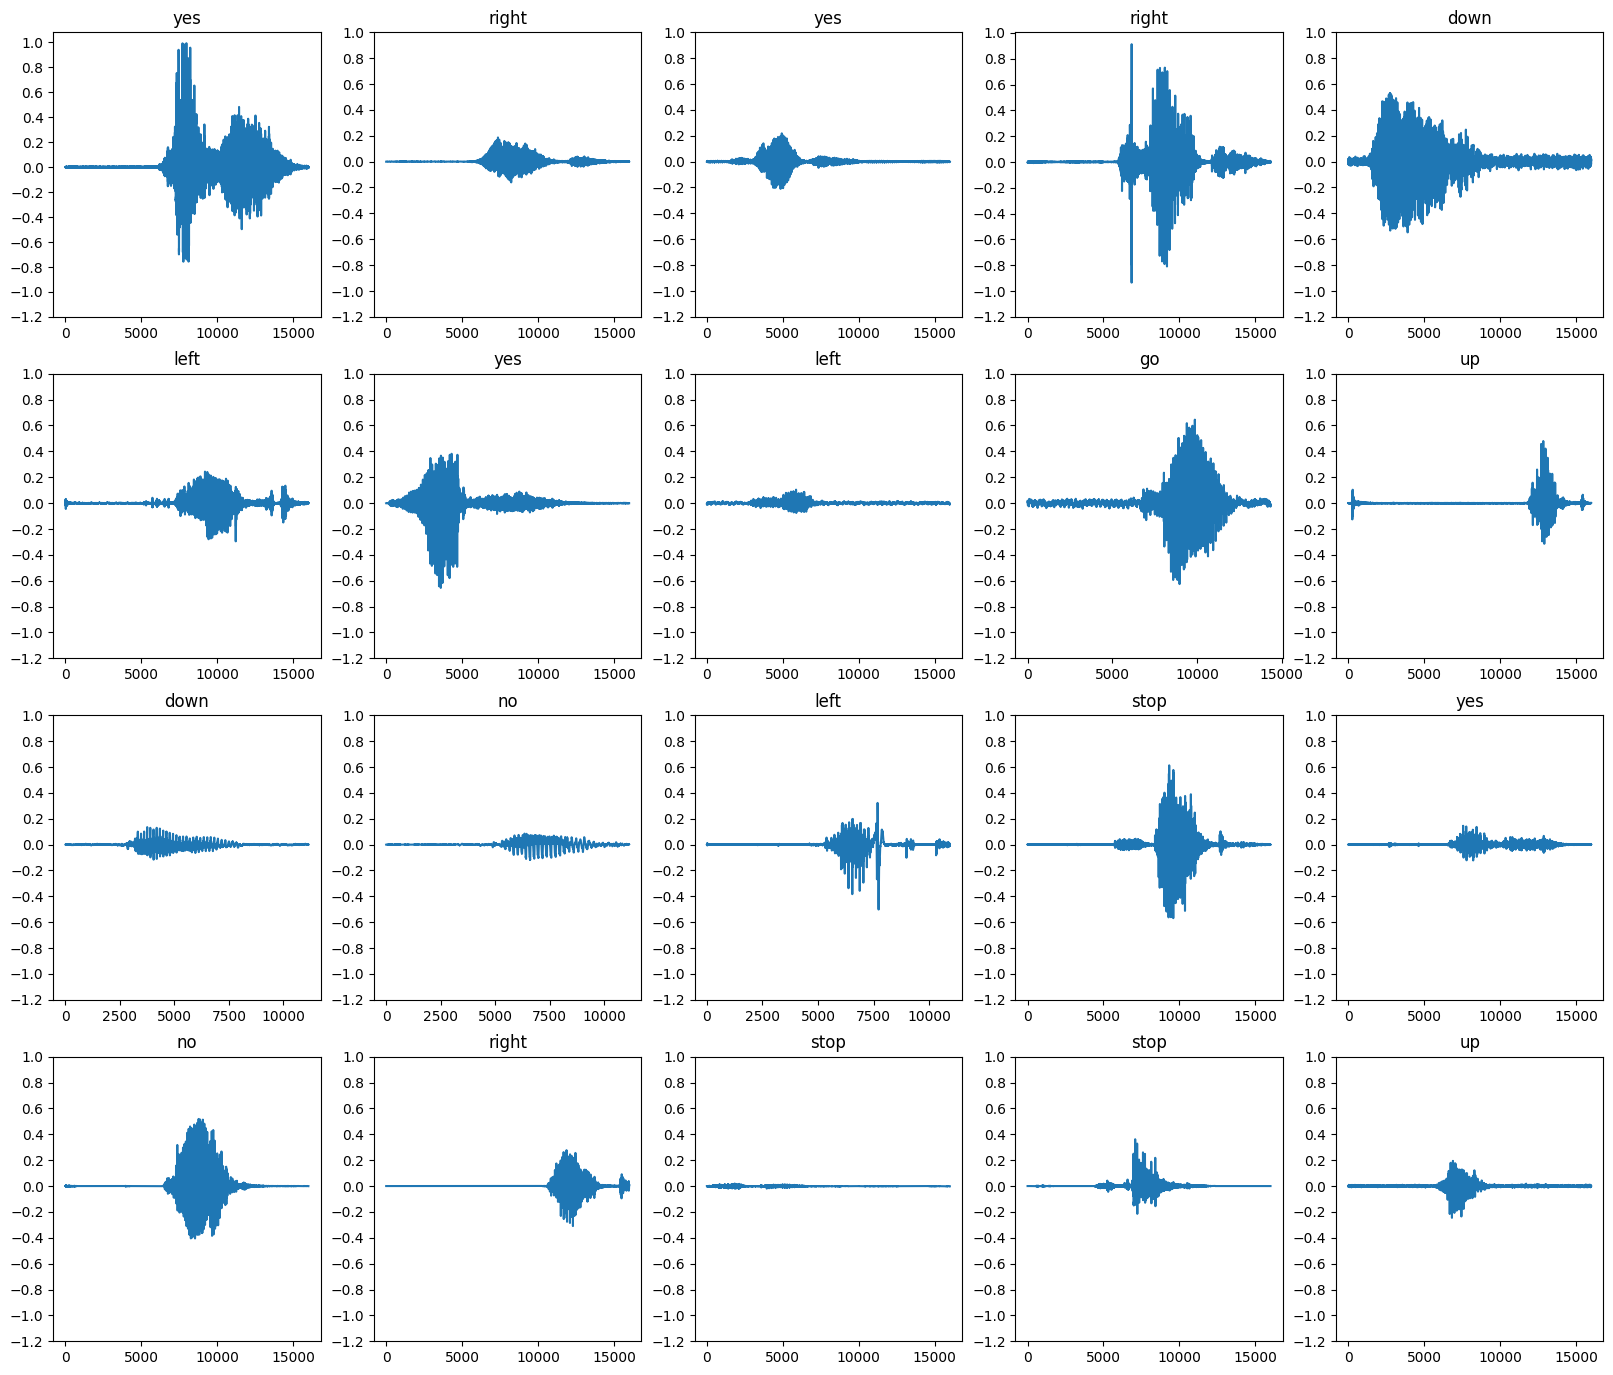

In [9]:
rows = 4
cols = 5
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 17))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [10]:
for waveform, label in waveform_ds.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


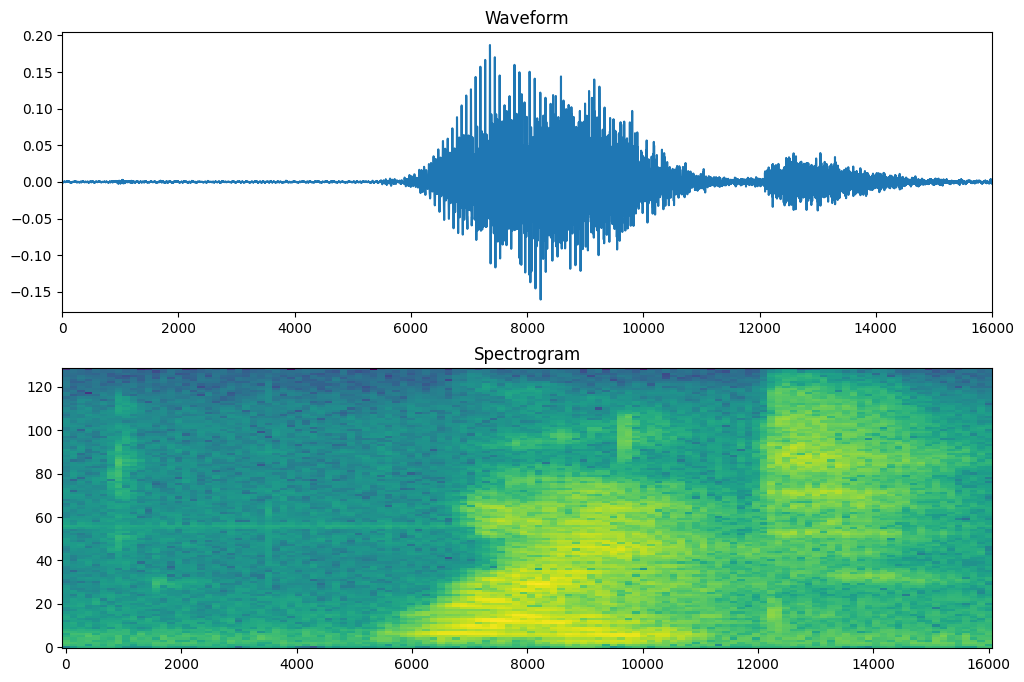

In [11]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [12]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [13]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

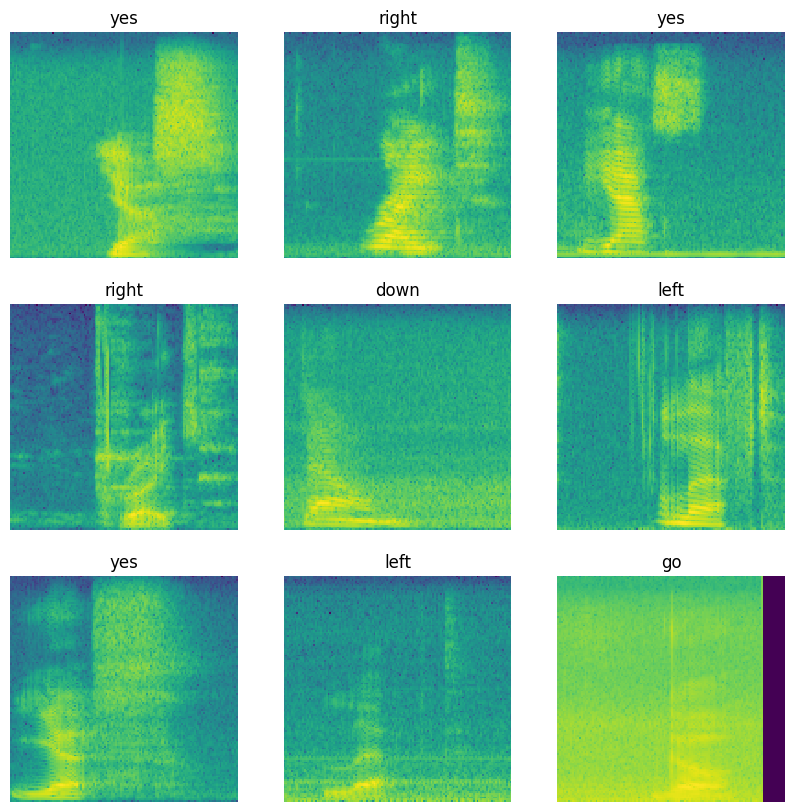

In [14]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [15]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [16]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(validation_data)
test_ds = preprocess_dataset(test_data)

In [17]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [18]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [34]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.LayerNormalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
# norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.experimental.preprocessing.Resizing(32, 32),
    # Normalize.
    # norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
EPOCHS = 20
history = model.fit(
    train_ds,
    batch_size = 64,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
100/100 [==============================] - 19s 181ms/step - loss: 2.0413 - accuracy: 0.2149 - val_loss: 1.9686 - val_accuracy: 0.2412
Epoch 2/20
100/100 [==============================] - 17s 171ms/step - loss: 1.3089 - accuracy: 0.5159 - val_loss: 1.8325 - val_accuracy: 0.3063
Epoch 3/20
100/100 [==============================] - 19s 190ms/step - loss: 0.9181 - accuracy: 0.6626 - val_loss: 1.4370 - val_accuracy: 0.5987
Epoch 4/20
100/100 [==============================] - 19s 190ms/step - loss: 0.6879 - accuracy: 0.7454 - val_loss: 0.8413 - val_accuracy: 0.8037
Epoch 5/20
100/100 [==============================] - 19s 191ms/step - loss: 0.5446 - accuracy: 0.7920 - val_loss: 0.5917 - val_accuracy: 0.8512
Epoch 6/20
100/100 [==============================] - 19s 189ms/step - loss: 0.4916 - accuracy: 0.8343 - val_loss: 0.4123 - val_accuracy: 0.8662
Epoch 7/20
100/100 [==============================] - 19s 190ms/step - loss: 0.4152 - accuracy: 0.8508 - val_loss: 0.4082 - val_ac

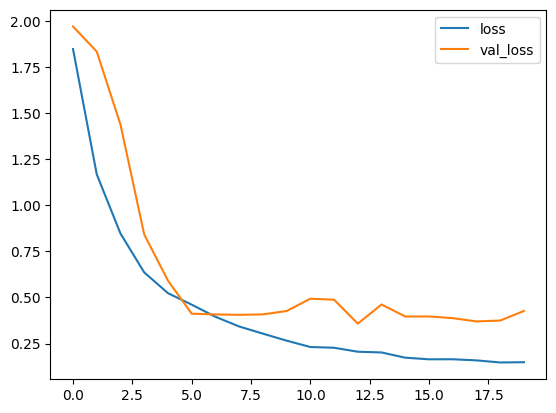

In [37]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [38]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [39]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 90%


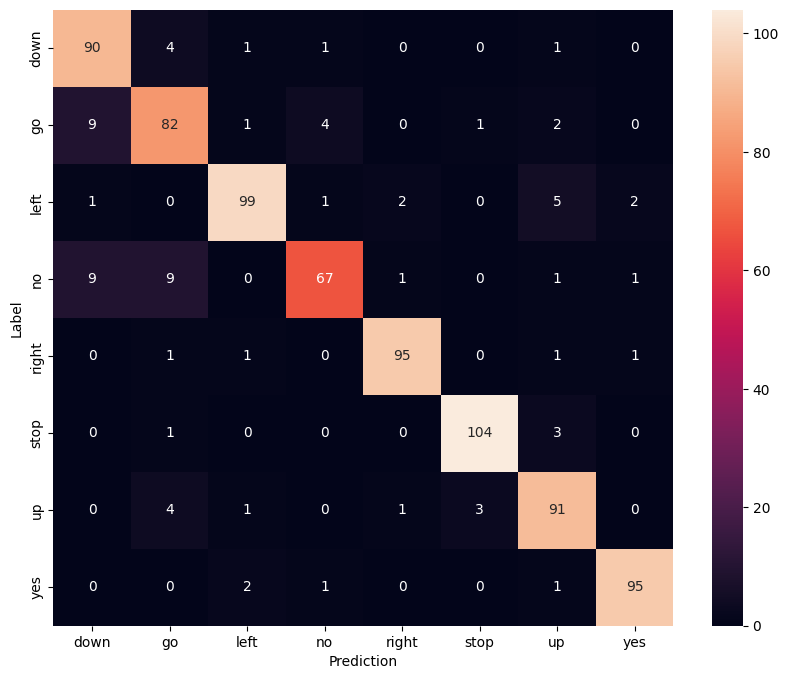

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

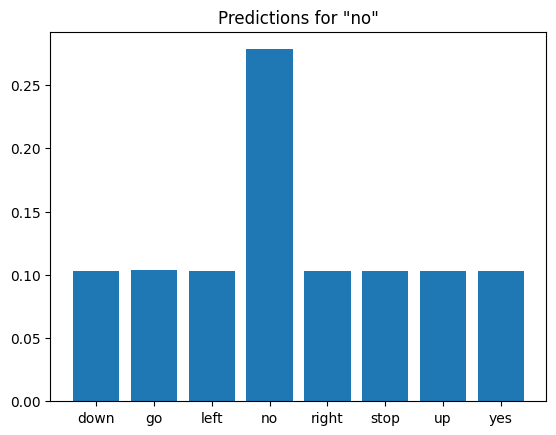

In [41]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')

  # print(commands[label(0)])
  plt.show()
  # print(commands[label[0]])

In [42]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("detection_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("detection_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\phamh\AppData\Local\Temp\tmpqlg3ywov\assets
Model is 2770880 bytes
